#ANTECEDENTES

In [1]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      # Instalar rdkit
      !pip -q install rdkit.pypi==2021.9.4
      pbar.update(20)
      # Instalar Pillow
      !pip -q install Pillow
      pbar.update(40)
      # Instalar molplotly
      !pip install molplotly
      pbar.update(60)
      # Instalar jupyter-dash
      !pip install jupyter-dash
      pbar.update(80)
      !pip install gdown
      pbar.update(90)
      # Instalar el diseño de aplicación dash
      !pip install dash-bootstrap-components

      pbar.update(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.feature_selection import (SelectFromModel, SelectKBest,
                                       VarianceThreshold)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import dash_bootstrap_components as dbc
from sys import argv
import molplotly
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors


#DATOS

In [3]:
# descargamos data
! gdown --id 1ne37Ybkx6ACrsuH8PzE8oDaLVd9fUmUV
#! gdown --id 1IP9OgHFe22QLbTGcnLHom6o2_NmJG5r6JIda7cmy16M
DATA = pd.read_excel('nlz_activity_2.xlsx')
DATA.head(2)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ne37Ybkx6ACrsuH8PzE8oDaLVd9fUmUV
To: /content/nlz_activity_2.xlsx
100% 12.3k/12.3k [00:00<00:00, 23.5MB/s]


,Cmpd,mol,pIC50,group,group_1
0,Cheng 2a,Clc1cc([N+](=O)[O-])ccc1N1CCN(CC1)C(=O)c1c(onc...,5.316053,data,Cheng
1,Cheng 2b,Clc1cc([N+](=O)[O-])ccc1N1CCN(CC1)C(=O)c1c(onc...,6.148742,data,Cheng


In [4]:
# Cambiar nombre a columnas
DATA.columns = ["Cmpd", "SMILES", "pIC50", 'G', 'G1']
DATA.head(2)

,Cmpd,SMILES,pIC50,G,G1
0,Cheng 2a,Clc1cc([N+](=O)[O-])ccc1N1CCN(CC1)C(=O)c1c(onc...,5.316053,data,Cheng
1,Cheng 2b,Clc1cc([N+](=O)[O-])ccc1N1CCN(CC1)C(=O)c1c(onc...,6.148742,data,Cheng


In [5]:
! gdown --id 15_53k_O6oSfQ5bDKJl-jIGmzVbpVzFW3

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15_53k_O6oSfQ5bDKJl-jIGmzVbpVzFW3
To: /content/explor2_predictions.xlsx
100% 12.3k/12.3k [00:00<00:00, 17.7MB/s]


In [6]:
dataset_explor2 = pd.read_excel("explor2_predictions.xlsx")
dataset_explor2.head(2)

,name,smiles,pred,Leverage,OneClassSVM
0,2 Me pip R,Clc1cc([N+](=O)[O-])ccc1N1CC(N(CC1)C(=O)c1c(no...,6.956891,0.598765,-0.007845
1,2 Me pip S,Clc1cc([N+](=O)[O-])ccc1N1CC(N(CC1)C(=O)c1c(no...,6.934997,0.604001,-0.007756


In [7]:
dataset_explor2 = dataset_explor2.drop(index=list(range(0, 13)))

In [8]:
#dataset_explor2

In [9]:
# prompt: en dataset_explor2 agrega una nueva columna que se llame 'G' y todos sus elementos digan 'explor_2', y otra que se llame 'G1' y que todos digan ''explor_2'

dataset_explor2['G'] = 'explor_2'
dataset_explor2['G1'] = 'explor_2'


In [10]:
#dataset_explor2.head(2)

In [11]:
# Cambiar nombre a columnas
dataset_explor2.columns = ["Cmpd", "SMILES", "pIC50", 'Leverage', 'OneClassSVM', 'G','G1']
#dataset_explor2.head(2)

In [12]:
#Concatenamos los DataFrames
combined_dataset = pd.concat([DATA, dataset_explor2], ignore_index=True)
#combined_dataset.head(5)

En esta celda vamos a descargar el dataframe combined_dataset para calcular los descriptores moleculares de SWISS-ADME y se volveran a subir con !gdown

In [13]:
# Este código sirve para desscargar combined_dataset
#combined_dataset.to_csv('combined_dataset.csv', index=False)
#from google.colab import files
#files.download('combined_dataset.csv')

In [14]:
#Con este código vamos cargar un archivo .csv con los datos calculados de
#SWISS-ADME cargados en drive con --id
!gdown --id 1Ta-2tJ2GnQ_ZujgBTuyE4OFCZab_I0nf
DATA_solubility = pd.read_csv('combined_dataset_1.csv')
#DATA_solubility.head(2)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ta-2tJ2GnQ_ZujgBTuyE4OFCZab_I0nf
To: /content/combined_dataset_1.csv
100% 48.2k/48.2k [00:00<00:00, 4.47MB/s]


In [15]:
DATA = combined_dataset

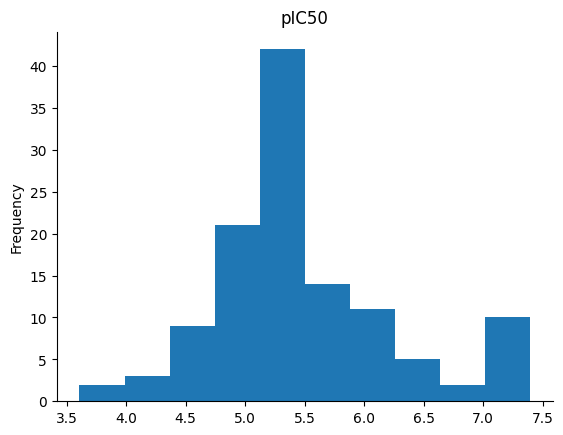

In [16]:
#visualizamos el histogramade pIC50
from matplotlib import pyplot as plt
DATA['pIC50'].plot(kind='hist', bins=10, title='pIC50')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
# Generar descriptores con RDKIT
DATA["HBA"] = [Descriptors.NumHAcceptors(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["HBD"] = [Descriptors.NumHDonors(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["RB"] = [Descriptors.NumRotatableBonds(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["LogP"] = [Descriptors.MolLogP(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["TPSA"] = [Descriptors.TPSA(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["MW"] = [Descriptors.MolWt(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]

In [18]:
# Visualizamos los datos en forma de matiz con matplotly
import plotly.express as px
fig = px.scatter_matrix(DATA,
    dimensions=["HBA", "HBD", "RB", "LogP", "TPSA", "MW", 'pIC50'],
    color="G",
            hover_name='Cmpd')
fig.update_traces(diagonal_visible=False)
fig.update_layout(plot_bgcolor='white')
fig.show()

In [19]:
# prompt: con la última matriz calcula una matriz de corelación, y proyectala con plotly y hazla de color azul

# Calcular la matriz de correlación
corr_matrix = DATA[["HBA", "HBD", "RB", "LogP", "TPSA", "MW", 'pIC50']].corr()

# Crear el gráfico de matriz de correlación con Plotly
fig = px.imshow(corr_matrix,
                text_auto=True,
                color_continuous_scale='Blues',
                labels=dict(color="Correlation"))

# Mostrar el gráfico
fig.show()


In [20]:
#aquí definimos cualquier gráfica de dispersión (scatter) que nos interese
fig = px.scatter(DATA, x="MW", y="LogP", color="G")
fig.update_layout(plot_bgcolor='white')
app_marker = molplotly.add_molecules(fig=fig,
                                         df=DATA,
                                         smiles_col='SMILES',
                                         title_col='Cmpd',
                                         color_col='G'
                                        )
app_marker.run(port=8060)

/usr/local/lib/python3.10/dist-packages/dash/dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



<IPython.core.display.Javascript object>

In [21]:
# Repitimos la mimsa gráfica en 3D y agregamos una dimensión extra que será pIC50
fig_ = px.scatter_3d(DATA, x="MW", y="LogP", z="pIC50", color="G", hover_name='Cmpd')
fig_.update_layout(plot_bgcolor='white')
fig_.show()

In [22]:
dataset = DATA[["Cmpd", "HBA", "HBD", "RB", "LogP", "TPSA", "MW"]]
dataset.head(2)

,Cmpd,HBA,HBD,RB,LogP,TPSA,MW
0,Cheng 2a,6,0,4,4.17402,92.72,426.860
1,Cheng 2b,7,0,5,4.18262,101.95,456.886


# Generar PCA

## 1. Dividir base de datos

In [23]:
#Dividir matriz
data = dataset.iloc[:,1:7].values # Seleccionar columnas con descriptores
label = dataset.iloc[:,0].values # Seleccionar el nombre de la base de datos(label) de las columnas

In [24]:
pd.DataFrame(data).head(3)#, columns = label)

,0,1,2,3,4,5
0,6.0,0.0,4.0,4.17402,92.72,426.860
1,7.0,0.0,5.0,4.18262,101.95,456.886
2,7.0,0.0,4.0,3.09972,97.40,426.864


In [25]:
# Normalizar datos
from sklearn.preprocessing import StandardScaler
data_std = StandardScaler().fit_transform(data)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_results = pca.fit_transform(data_std)
#pca_results

In [27]:
# Seleccionar impormación complementaria
label = DATA[["Cmpd", "SMILES", "pIC50", 'G', 'G1']]
label = label.to_numpy()

In [28]:
# Concatenar arrays de numpy
arr = np.concatenate((label, pca_results), axis = 1)
# Crear un nuevo dataframe
pca_dataset = pd.DataFrame(data=arr, columns = ['Cmpd',"SMILES", "pIC50",'G','G1','component1', 'component2', 'component3'])
pca_dataset.head(2)

,Cmpd,SMILES,pIC50,G,G1,component1,component2,component3
0,Cheng 2a,Clc1cc([N+](=O)[O-])ccc1N1CCN(CC1)C(=O)c1c(onc...,5.316053,data,Cheng,-0.901432,0.115142,-0.075538
1,Cheng 2b,Clc1cc([N+](=O)[O-])ccc1N1CCN(CC1)C(=O)c1c(onc...,6.148742,data,Cheng,0.171873,0.69359,-0.267233


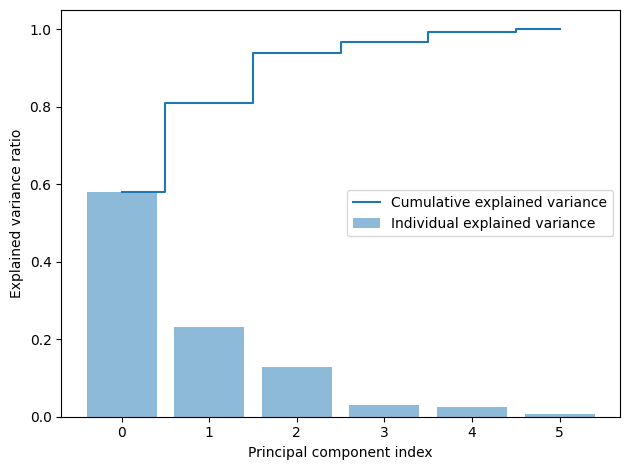

In [29]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(data)
X_train_std = sc.transform(data)
#X_test_std = sc.transform(X_test)
# Instantiate PCA
pca = PCA()

# Determine transformed features
X_train_pca = pca.fit_transform(X_train_std)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
import matplotlib.pyplot as plt
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [30]:
#pca_dataset

In [31]:
set(list(pca_dataset["G1"]))

{'Cheng', 'Kao', 'Liao', 'Liao_39', 'Pai', 'Su', 'Wang', 'explor_2', 'nlz'}

In [32]:
#Grafica los primeros dos Componentes Principales
fig_pca = px.scatter(pca_dataset,
                            x='component1',
                            y='component2',
                            #symbol='Minimum Degree',
                            #color='G1',
                            color='G',
                            #hover_data='pIC50',
                            #color_discrete_sequence=["indigo", "green", 'orange','red'],
                            title='PCA',
                            labels={'PC1': 'PC_1',
                                    'PC2': 'PC_2'},
                            width=1050,
                            height=750)
fig_pca.update_layout(plot_bgcolor='white')
app_marker = molplotly.add_molecules(fig=fig_pca,
                                         df=pca_dataset,
                                         smiles_col='SMILES',
                                         title_col='Cmpd',
                                         color_col='G'
                                        )
#fig_pca.show()
#app_marker.run_server(mode='inline', port=8060, height=1000)
app_marker.run(port=8060)


/usr/local/lib/python3.10/dist-packages/dash/dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



<IPython.core.display.Javascript object>

In [33]:
#Graficar
import plotly.express as px
import molplotly
fig_pca = px.scatter(pca_dataset,
                            x='component1',
                            y='component2',
                            #symbol='Minimum Degree',
                            color='G1',
                            hover_data='pIC50',
                     hover_name= 'Cmpd',
                            #color_discrete_sequence=["indigo", "green", 'orange','red'],
                            title='PCA',
                            labels={'PC1': 'PC_1',
                                    'PC2': 'PC_2'},
                            width=1050,
                            height=750)
fig_pca.update_layout(plot_bgcolor='white')
fig_pca.show()


In [34]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(DATA,'SMILES', 'structure') #Agrega una columna de estructura al dataframe

In [35]:
# visualizamos las esctructuras de los compuestoa junto a su actividad cálculada
from rdkit.Chem import Draw
Draw.MolsToGridImage([x for x in DATA["structure"]],#[:20],
                     #maxMols=100,
                     legends=[str(x) for x in DATA.pIC50],
                     subImgSize=(350,350), molsPerRow=3
                     )

Output hidden; open in https://colab.research.google.com to view.

#SOLUBILIDAD Y DESCRIPTORES FARMACOCINÉTICOS

Ahora vamos a visualizar las solubilidades calculadas por SWISS-ADME

In [36]:
# Creamos una matriz de dispersión
fig = px.scatter_matrix(DATA_solubility,
    dimensions=[#'pIC50', 'Leverage', 'LogP',
                'TPSA', #'MW', #' TPSA.1',
       #'ESOL Log S', 'ESOL Solubility (mg/ml)',
                'ESOL Solubility (mol/l)',
       #' Ali Log S', 'Ali Solubility (mg/ml)',
       'Ali Solubility (mol/l)', #'Ali Class', 'Silicos-IT LogSw',
       #'Silicos-IT Solubility (mg/ml)',
                'Silicos-IT Solubility (mol/l)'
                ],
    color="G")
fig.update_layout(plot_bgcolor='white')
fig.show()

In [37]:
#Grafica la solubilidad en un scatter
import plotly.express as px
import molplotly
fig = px.scatter(DATA_solubility,
                            x='TPSA',
                            y='ESOL Solubility (mol/l)',
                            #symbol='Minimum Degree',
                            #color='G1',
                     color='G',
                            #hover_data='pIC50',
                            #color_discrete_sequence=["indigo", "green", 'orange','red'],
                            title='PCA',
                            labels={'PC1': 'PC_1',
                                    'PC2': 'PC_2'},
                            width=1050,
                            height=750
                     )

fig.update_layout(plot_bgcolor='white')
app_marker = molplotly.add_molecules(fig=fig,
                                         df=DATA_solubility,
                                         smiles_col='SMILES',
                                         title_col='Cmpd',
                                         color_col='G',
                                                                             )
app_marker.run(port=8060)

/usr/local/lib/python3.10/dist-packages/dash/dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



<IPython.core.display.Javascript object>

In [38]:
# prompt: repite la ultima grafica en #D y agrega pIC50, has más pequeños los puntos

fig = px.scatter_3d(DATA_solubility,
                    x='TPSA',
                    y='ESOL Solubility (mol/l)',
                    z='pIC50',
                    color='G',
                    hover_name='Cmpd',
                    size_max=10)
fig.show()


creado por el Dr. Erick Correa Padilla, F.E.S. Zaragoza-UNAM, para el Congreso de la Sociedad Química de México 2024